# Statistical Rethinking Chapter 5

## Codeblocks

In [28]:
library('rethinking')

In [29]:
data(WaffleDivorce)
d <- WaffleDivorce

In [30]:
d$D <- standardize(d$Divorce)
d$M <- standardize(d$Marriage)
d$A <- standardize(d$MedianAgeMarriage)

#### An initial linear model

In [31]:
m5.1 <- quap(
    alist(
        D ~ dnorm(mu, sigma),
        mu <- a + bA * A ,
        a ~ dnorm(0, 0.2) ,
        bA ~ dnorm(0, 0.5) ,
        sigma ~ dexp(1)   
    ),
    data = d
)

#### Choice of priors:  
**a:** since outcome and predictor are both standardized, a should end up very close to 0.  
**bA:** describes the change in divorce when changing the median age. Example: assume bA=1, then a change in median age by one standard deviation would change divorce rate also by one standard deviation. Is that a strong relationship? Let's look at the standard deviation of MedianAgeMarriage:

In [32]:
sd(d$MedianAgeMarriage)

[1] 1.24363

So a change in median age at marriage by 1.2 years would cause a change in divorce by 1 sd, which looks like a very strong relationship. However, our prior thinks that only 5% of all plausible parameters for bA are that strong.

#### Simulating from the prior

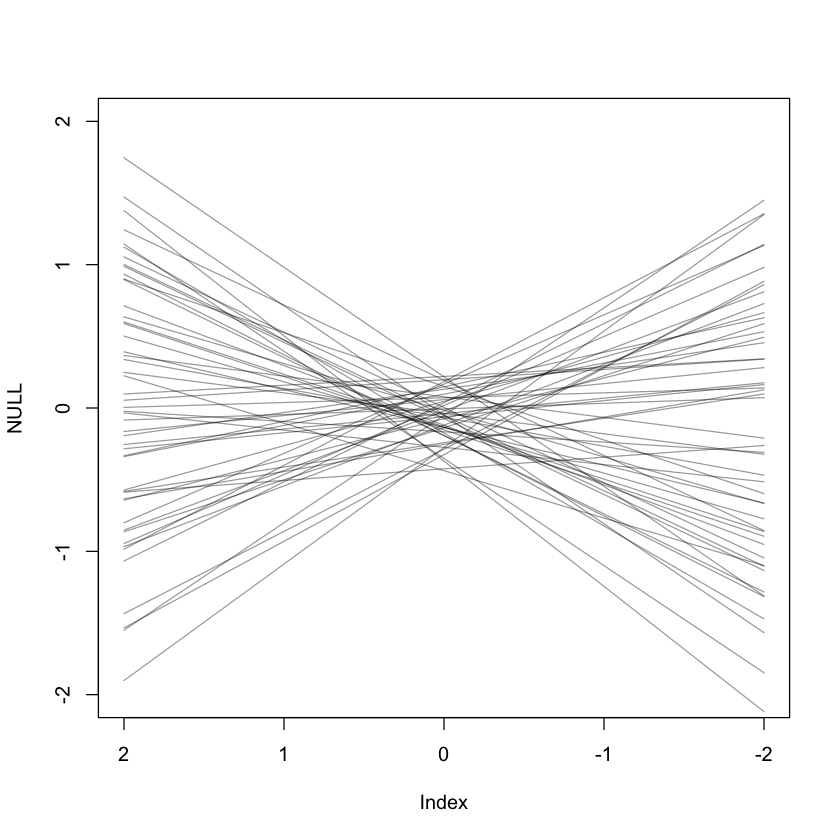

In [33]:
set.seed(10)
prior <- extract.prior(m5.1)
mu <- link(m5.1, post=prior, data=list(A=c(-2,2)))
plot(NULL, xlim=-c(-2,2), ylim=c(-2,2))
for(i in 1:50) lines(c(-2,2), mu[i, ], col=col.alpha("black", 0.4))

#### Simulating from the posterior

In [34]:
A_seq <- seq(from=-3, to=3.2, length.out=30)
mu <- link(m5.1, data=list(A=A_seq))
mu.mean <- apply(mu, 2, mean)
mu.PI <- apply(mu, 2, PI)

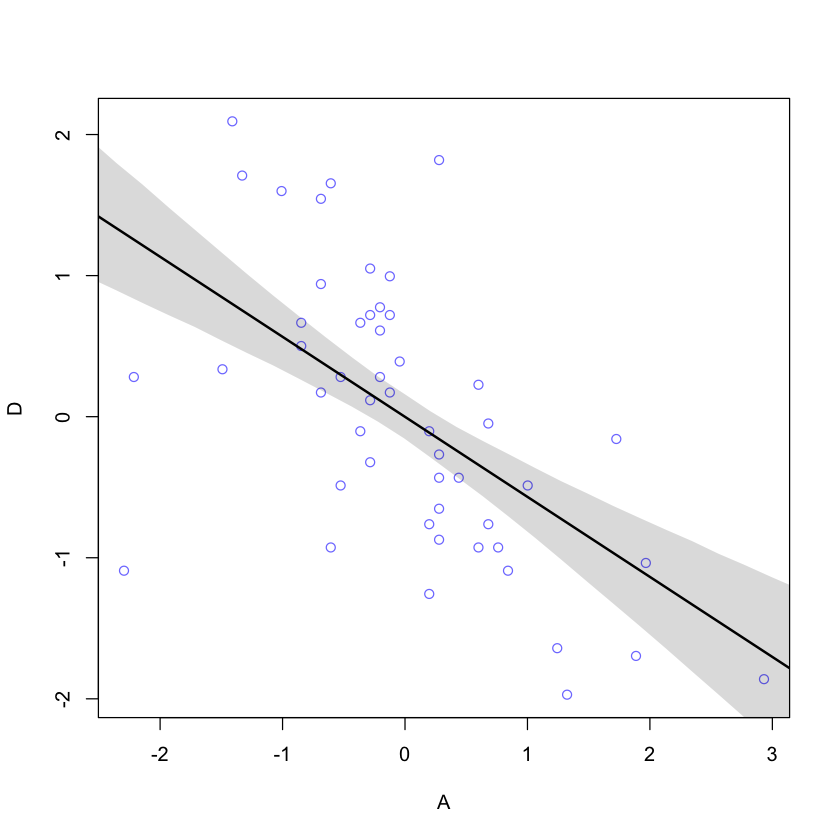

In [35]:
plot(D ~ A, data=d, col=rangi2)
lines(A_seq, mu.mean, lwd=2)
shade(mu.PI, A_seq)

## Multiple regression

In [38]:
m5.3 <- quap(
    alist(
        D ~ dnorm(mu, sigma),
        mu <- a + bM * M + bA * A,
        a ~ dnorm(0, 0.2),
        bM ~ dnorm(0, 0.5), 
        bA ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ), data=d)

In [41]:
precis(m5.3)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,2.532408e-07,0.09707607,-0.1551461,0.1551466
bM,-6.537834e-02,0.15077315,-0.3063430,0.1755863
bA,-6.135116e-01,0.15098369,-0.8548127,-0.3722105
sigma,7.851184e-01,0.07784350,0.6607095,0.9095273


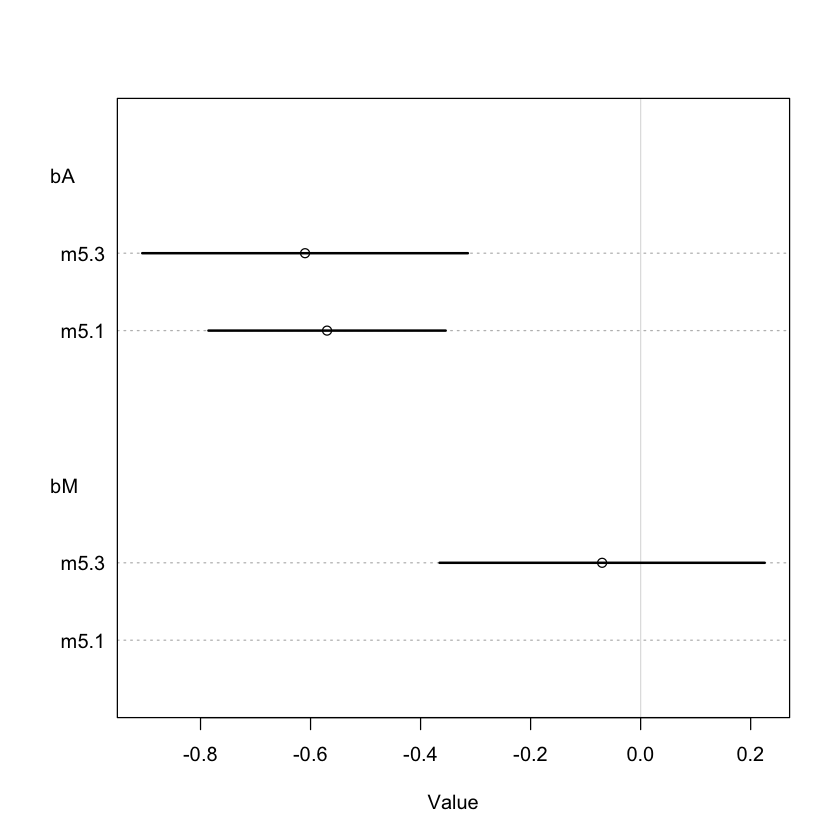

In [43]:
plot(coeftab(m5.1,  m5.3), par=c('bA', 'bM'))

In [44]:
?coeftab

coeftab {rethinking},R Documentation
...,"A series of fit models, separated by commas"
se,Include standard errors in table?
se.inside,Print standard errors in same cell as estimates
nobs,Print number of observations for each model?
digits,Number of digits to round numbers to
rotate,"If TRUE, rows are models and columns are coefficients"


## Plotting multivariate posteriors

### Residual plots

We regress A on M

In [45]:
m5.4 <- quap(
    alist(
        M ~ dnorm(mu, sigma),
        mu <- a + bAM * A,
        a ~ dnorm(0, 0.2),
        bAM ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ), data=d
)

find the "regression line" 

In [46]:
mu <- link(m5.4)
mu_mean <- apply(mu, 2, mean)

In [119]:
#?link

"subtract the regression line"

In [48]:
mu_resid <- d$M - mu_mean

In [120]:
#head(mu_resid)

regressing the residuals from m5.4 (residuals of M) on D

In [82]:
m5.4.res.d <- data.frame(D = d$D, res = mu_resid)

In [87]:
m5.4.res <- quap(
    alist(
        D ~ dnorm(mu, sigma),
        mu <- a + b * res,
        a ~ dnorm(0, 0.2),
        b ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    
    ), data=m5.4.res.d

)

calculating mu and compatibility intervals

In [121]:
mu_seq <- seq(from=-2, to=2, length.out=30)
mu <- link(m5.4.res, data=list(res=mu_seq))

In [122]:
mu_mean <- apply(mu, 2, mean)
mu_PI <- apply(mu, 2, PI)

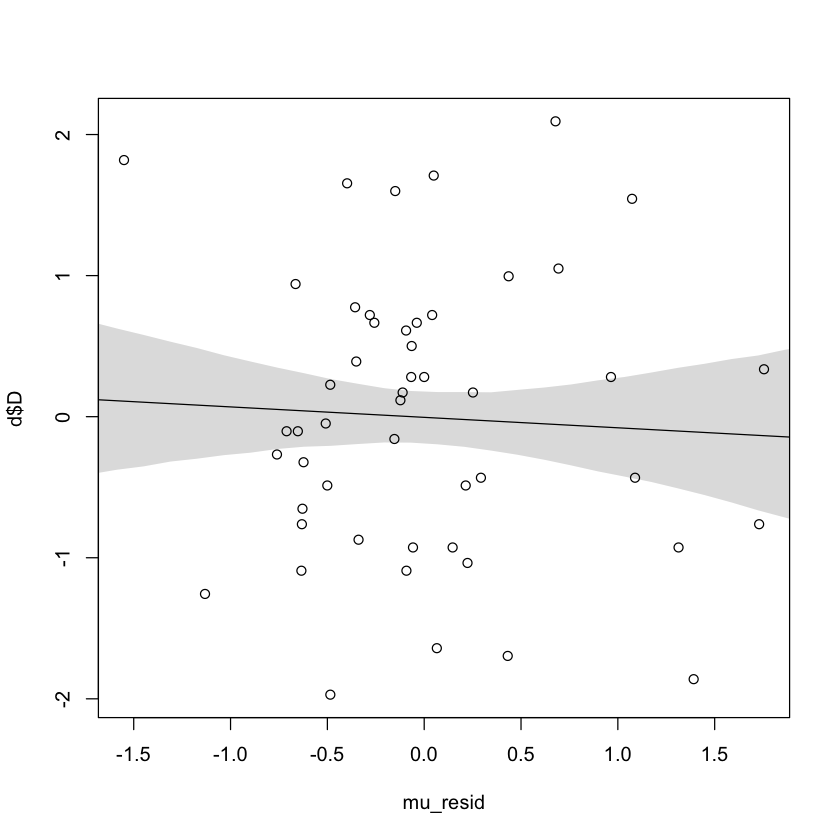

In [123]:
plot(d$D ~ mu_resid)
lines(mu_seq, mu_mean)
shade(mu_PI, mu_seq)

Sidenote: Apparently, `plot()`, `lines()` and `shade()` take in x and y in different order. While plot and shade take y first, lines puts the first argument on the x axis.

#### Main takeaway
What we did here is taking out the information of age at marriage (A) from marriage rate (M) and explored whether the remaining information (= the residuals) still have some value for the model. We found that after conditioning on age at marriage (A), the remaining variation in marriage rate (M) is not informative of divorce (D).

Out of curiosity, here's a simple linear regression of mu_resid on divorce. The result is similar: a and b are not significantly different from 0 and the effect size is minimal. 

In [79]:
m.lin.1 <- lm(d$D ~ mu_resid)
summary(m.lin.1)


Call:
lm(formula = d$D ~ mu_resid)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.01023 -0.78651  0.00824  0.65810  2.14932 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept) -9.782e-05  1.427e-01  -0.001    0.999
mu_resid    -8.207e-02  2.078e-01  -0.395    0.695

Residual standard error: 1.009 on 48 degrees of freedom
Multiple R-squared:  0.003239,	Adjusted R-squared:  -0.01753 
F-statistic: 0.156 on 1 and 48 DF,  p-value: 0.6946


### Posterior Predicition Plots

Essentially, we check the model's implied predictions against the observed data

In [124]:
mu <- link(m5.3)

In [125]:
mu_mean <- apply(mu, 2, mean)
mu_PI <- apply(mu, 2, PI)

In [126]:
D_sim <- sim(m5.3, n=1e4)

In [127]:
D_PI <- apply(D_sim, 2, PI)

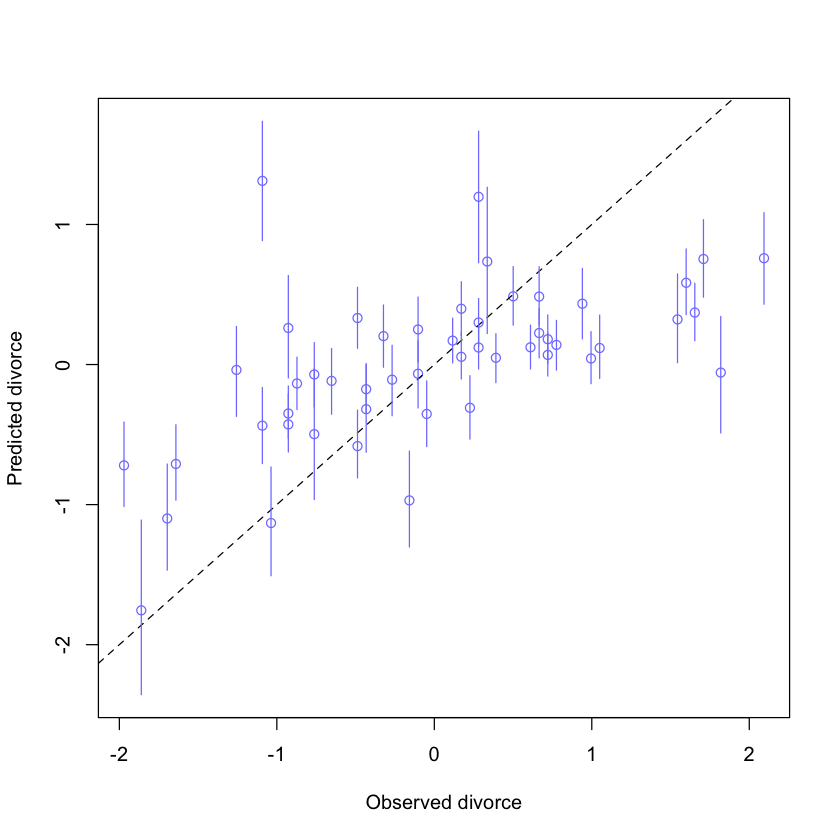

In [135]:
plot(mu_mean ~ d$D, col=rangi2, ylim=range(mu_PI), 
    xlab='Observed divorce', ylab='Predicted divorce')
abline(a=0, b=1, lty=2)
for(i in 1:nrow(d)) lines(rep(d$D[i], 2), mu_PI[, i], col=rangi2)
#identify(x=d$D, y=mu_mean, labels=d$Loc)

### Counterfactual Plots